# Summary of Model Findings


### Introduction
For our project, we decided to make a classifier that determines the gender targeting values for an ad. The evaluation metric we used was accuracy, since it seems like the most important job of a classifier: classifying unseen data accurately. We chose to predict the gender targeting of the ad because when we were trying to do linear regression to predict Spend or Impressions, we were unable to improve the accuracy of our prediction in any meaningful way, and most of the other categorical values in the dataset are too often nan for us to have any significant amount of data for testing.

### Baseline Model
For the baseline, we constructed a DecisionTreeClassifier that looks at the Impression & Spend columns (Which are both quantitative). It was pretty accurate: achieving ~82% accuracy on the test set. We thought that 82% is pretty good, but felt that we could top this accuracy.

### Final Model
For the final model, we collapsed the two features that the baseline model took in: Impressions & Spend, and we turned them into a single feature: DollarPerView. This feature gives us largely the same info as the columns seperately, reducing the complexity of our model. The second feature that we added is Country which is that 2-letter country code from each row's BillingAddress value. We tried out the RandomForestClassifier as well, but the results were nearly identical, so we stuck with the DTC. We ran a GridSearchCV to optimize the parameter tuning of our model for criterion, max_depth ,min_samples_split & min_samples_leaf, see code below for optimal values. The results were okay: it's ~8% more accurate than the baseline. When we tried running the model with more columns, the noise from them made our accuracy go down.

### Fairness Evaluation
For the fairness evaluation, we look at whether the DollarPerView value is a spike (which we defined to be outside one standard deviation of average DPV) & evaluate the accuracy of our model to see whether it is systematically misclassifying Spikes.(The parity measure used is accuracy) This showed us that it certainly is misclassyfying spikes, and calls into question our decision to collapse the Impressions & Spend columns

# Code

In [239]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
df_18 = pd.read_csv("PoliticalAds_18.csv")
df_19 = pd.read_csv("PoliticalAds_19.csv")
#adding a year column to both 18 and 19 dataframe that contains the year
df_18 = df_18.assign(**{"Year": 18})
df_19 = df_19.assign(**{"Year": 19})
#concated the two years of information into one dataframe
catted_df = pd.concat([df_18, df_19])
#Fill in the gender targeting so that the nan value reflects what it means
catted_df['Gender_Filled'] = catted_df['Gender'].fillna('BOTH')


### Baseline Model

In [236]:
lm = DecisionTreeClassifier()
X = catted_df.drop(["Gender_Filled","Gender"], axis=1)
y = catted_df.Gender_Filled
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
lm = lm.fit(X_tr[["Impressions","Spend"]],y_tr)
num = lm.predict(X_ts[["Impressions","Spend"]])
num1 = lm.predict(X_tr[["Impressions","Spend"]])
(
 ("Base test accuracy", metrics.accuracy_score(num, y_ts)),
 ("Base Train Accuracy", metrics.accuracy_score(num1, y_tr))
)


(('Base test accuracy', 0.8268765133171913), ('Base Train Accuracy', 1.0))

### Final Model

In [240]:
#grabbed the countries from the mailing address
catted_df = catted_df.assign(**{"Country": catted_df['BillingAddress']
                                .apply(lambda x: x[-2:])})
#changed the start and end date to datetime objects 
#to be able to look at the data numerically
catted_df = catted_df.assign(**{"StartDate": pd.to_datetime(catted_df['StartDate'], 
                                                    infer_datetime_format = True)})
catted_df = catted_df.assign(**{"EndDate": pd.to_datetime(catted_df['EndDate'], 
                                                    infer_datetime_format = True)})
#created this function that converts the datetime object to a numerical value
def to_integer(dt_time):
    return 10000000000*dt_time.year + 100000000*dt_time.month + 
    1000000*dt_time.day + 10000*dt_time.hour + 100*dt_time.minute + dt_time.second
#converted all the start and end dates to numerical values
catted_df['StartDate'] = catted_df['StartDate'].apply(lambda x: to_integer(x))
catted_df['EndDate'] = catted_df['EndDate'].apply(lambda x: to_integer(x))
#filled the empty end date values with zero
catted_df['EndDate'].fillna(value = 0, inplace = True)
catted_df["AgeBracket"] = catted_df["AgeBracket"].fillna("All")
catted_df['Continent'] = catted_df['Country'].apply(country_to_continent)
catted_df = catted_df.assign(**{"DollarPerView": catted_df['Spend'] 
                              / catted_df['Impressions']})
spikes = (catted_df["DollarPerView"] > catted_df["DollarPerView"].mean() 
          + catted_df["DollarPerView"].std())
        |(catted_df["DollarPerView"] < catted_df["DollarPerView"].mean() 
          - catted_df["DollarPerView"].std())
#These are the ads with "Spikes" in DPV according to our original analysis 
catted_df["Spikes"] = spikes

X = catted_df.drop(["Gender_Filled","Gender"], axis=1)
y = catted_df.Gender_Filled

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.25)
lm.fit(X_tr[["Impressions","Spend"]],y_tr)
cat_feat = ["Country"]
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])
# preprocessing pipeline (put them together)
preproc = ColumnTransformer(transformers=[('cat', cat_transformer, cat_feat)])
pl = Pipeline(steps=[("preproc", preproc),('regressor', 
    DecisionTreeClassifier(max_depth=2))])
pl.fit(X_tr[["Country","DollarPerView"]], y_tr)
resid_test = pl.predict(X_ts[["Country","DollarPerView"]])
num = lm.predict(X_ts[["Impressions","Spend"]])
num1 = lm.predict(X_tr[["Impressions","Spend"]])
resid_train = pl.predict(X_tr[["Country","DollarPerView"]])
(
 ('pipe train accuracy', metrics.accuracy_score(resid_train, y_tr)),
 ('pipe test accuracy', metrics.accuracy_score(resid_test, y_ts)),
 ("base train accuracy", metrics.accuracy_score(num1, y_tr)),
 ("base test accuracy", metrics.accuracy_score(num, y_ts))
)


(('pipe train accuracy', 0.899071457408155),
 ('pipe test accuracy', 0.9128329297820823),
 ('base train accuracy', 1.0),
 ('base test accuracy', 0.8353510895883777))

In [228]:
from sklearn.model_selection import GridSearchCV
#This is to find the optimal paramaters for our DTC
tree_para = {"tree__max_depth":[2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,None], 
    'tree__min_samples_split':[2,3,5,7,10,15,20],
    'tree__min_samples_leaf':[2,3,5,7,10,15,20],
    "tree__criterion":["gini","entropy"]}
model = GridSearchCV(ps, param_grid=tree_para, cv=3, n_jobs=-1, verbose=1)
model = model.fit(X_tr[["Country","DollarPerView"]],y_tr)


Fitting 3 folds for each of 1568 candidates, totalling 4704 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2380 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 4704 out of 4704 | elapsed:   23.7s finished


In [229]:
#Gives us values of optimal params
model.best_params_


{'tree__criterion': 'gini',
 'tree__max_depth': 2,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 2}

In [230]:
(
 ("final test", model.score(X_ts[["Country","DollarPerView"]], y_ts)),
 ("final train", model.score(X_tr[["Country","DollarPerView"]], y_tr))
)


(('final test', 0.9116222760290557), ('final train', 0.8994751715785224))

This is a nice result, one of the biggest worries with a DTC is overfitting--it's heartening to see that our model has roughly the same accuracy over both test & train sets, this seems to indicate that it's not over fitting to the data in the train.

### Fairness Evaluation

For the Fairness test, we looked at whether the DPV (DollarPerView) column was a spike (which we defined to be outside of the interval mean dpv +/- 1 standard deviation), and whether our predictions was performing accurately on spikes. Hence, the fairness measure here is the simplest to use in a classification task: Accuracy Parity. Let a = .01.


In [232]:
results = catted_df.drop("Gender_Filled", axis = 1)
results["prediction"] = model.predict(results[["Country","DollarPerView"]])
results["tag"] = catted_df["Gender_Filled"]
obs = results.groupby('Spikes').apply(lambda x: metrics.accuracy_score(x.tag, 
                                                x.prediction)).diff().iloc[-1]
metrs = []
for _ in range(1000):
    s = (
        results[['Spikes', 'prediction', 'tag']]
        .assign(Spikes=results.Spikes.sample(frac=1.0, replace=False)
        .reset_index(drop=True))
        .groupby('Spikes')
        .apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
        .diff()
        .iloc[-1]
    )
    metrs.append(s)
    

pval 0.0


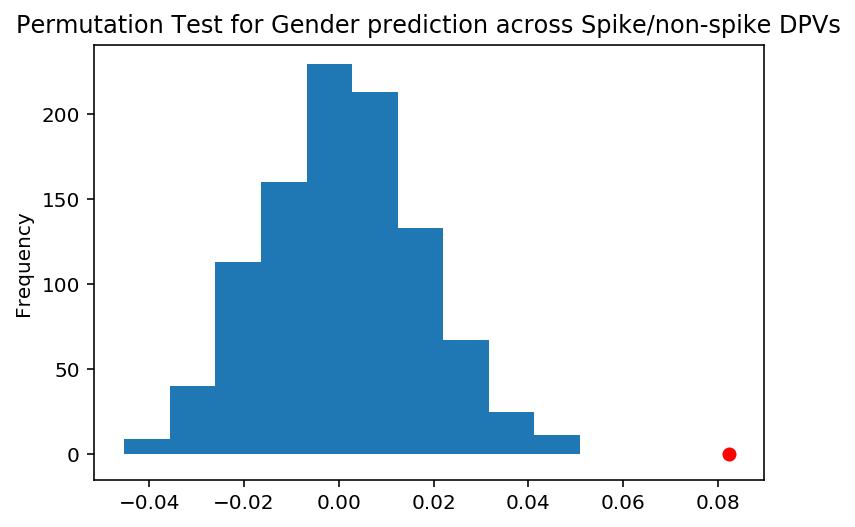

In [233]:
print("pval", 1 - pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', title='Permutation Test for Gender prediction across Spike/non-spike DPVs')
plt.scatter(obs, 0, c='r');


This Permutation tests tell us that there certainly is a difference in the accuracy of our prediction based on whether or not the value was a spike